## This notebook simulates the inverse scattering algorithm
The code is implemented based on "Polarization-Dependent Loss: New Definition and Measurement Techniques, 2015" by NO ́E et al." 

- The algorithm is susceptible to channel estimation noise
- We have proposed a learning-based approach which has a higher tolerance to estimation noise see ("M. Farsi, C.Häger, M. Karlsson, E. Agrell, "Learning to Extract Distributed Polarization Sensing Data from Noisy Jones Matrices")
- The algorithm experiences numerical instability when the number of segments increases (N>10)


Author: Mohammad Farsi 

Email: mohammad.farsi1994@gmail.com

In [51]:
import torch as tc
import numpy as np
from components.channelmodel import ChannelModel
from components.invscattering import InverseScattering

device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
print(device)

cpu


### Inverse Scattering: Parameter Setting

In [52]:
# Parameters
num_segments = 5 # Num of segments
num_freq_samples = num_segments*2 # Num of samples in frequency domain must be at least (num_segments+1)

# Inverse Scattering

tau = 1 # group delay normalized to 1

# Channel Model Object
h0_input = tc.eye(2).to(tc.double) # input to the channel according to eq(25)
chan_model = ChannelModel(num_segments=num_segments, h_init=h0_input, device='cpu')
# Channel Params
true_params = chan_model.gen_rnd_channel_params() # it returns a dict with keys {'gamma','phi', 'psi', 'tau'}
true_params['gamma'] = 0.07+0.1*true_params['gamma'] # sets the PDL in range of  [0.3, 0.7] dB

(ht, hf) = chan_model.sample_freq_response(num_freq_samples, true_params)
# Inverse Scattering Model
inverse_scatering = InverseScattering(num_segments=num_segments, tau=tau) # Inverse Scattering Object

# Add noise to the channel  
noise_var  = 0 # zero means perfect channel
data_temp = np.sqrt(noise_var)*np.random.multivariate_normal(mean=0*np.ones(2), cov = np.eye(2), size=2*num_freq_samples)
noise = tc.tensor(data_temp.reshape(num_freq_samples, 2, 2))
ht = ht + noise
#
(h0_est) = inverse_scatering.inverse_scattering(ht)
estimated_params = inverse_scatering.get_params()

#### True vs estimated $\gamma$, $\phi$, and $\psi$

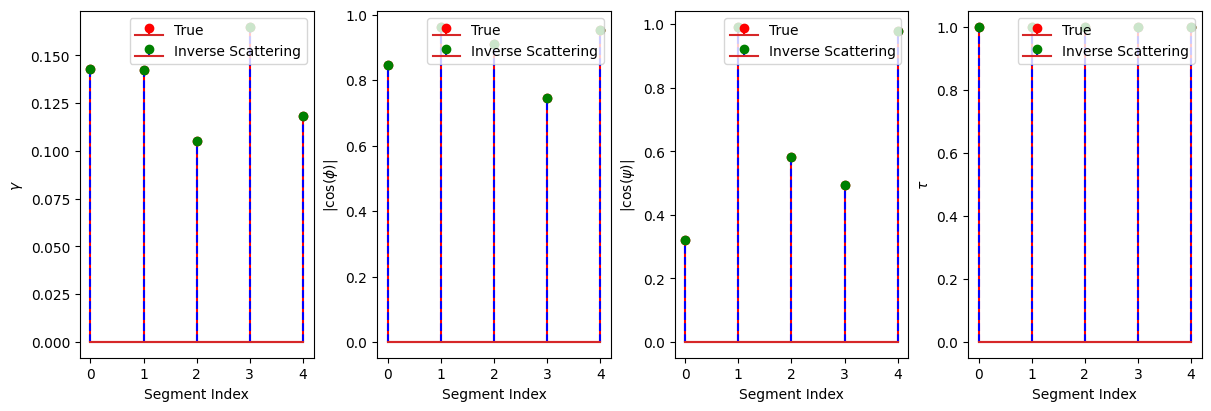

In [53]:
inverse_scatering.show_results(true_params, estimated_params)
